Pair trading is an extremely popular market-neutral strategy that profits from short-term deviations in the prices of historically co-moving assets. The traditional statistical models used for the investigation of such opportunities in these holds are cointegration with mean-reversion. However, most of the approaches collapse under volatile and non-linear market conditions.

Understanding the underlying behavior of the selected market would help design a machine learning long/short pair trading strategy. The primary asset for our analysis in this project is the currency pair EUR/USD. Best evidence needs to be presented by which a long/short strategy is market-neutral.

So we did a thorough market analysis spanning a decade between 2014 and 2024, digging into the market structure to determine whether EUR/USD mainly consists of uptrends, downtrends, or horizontal trends.

[*********************100%***********************]  1 of 1 completed


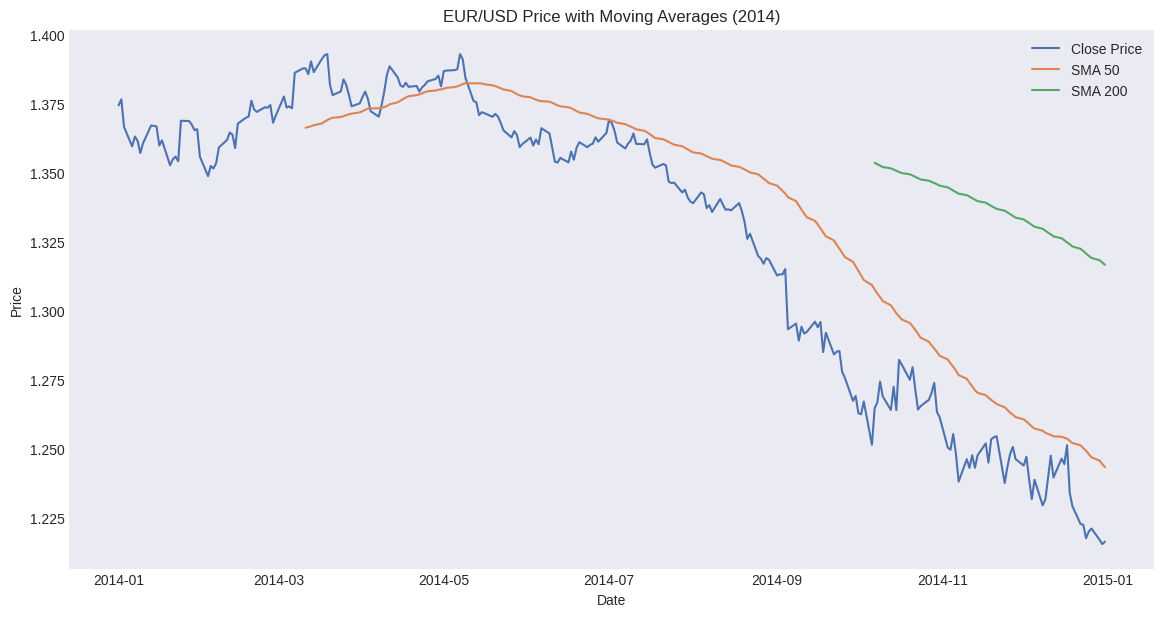

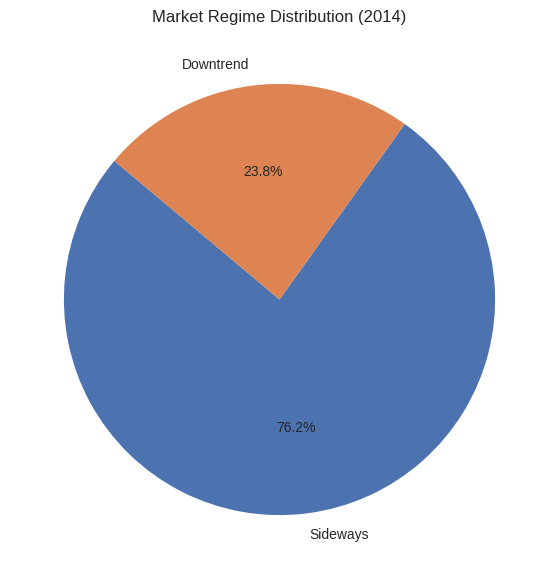

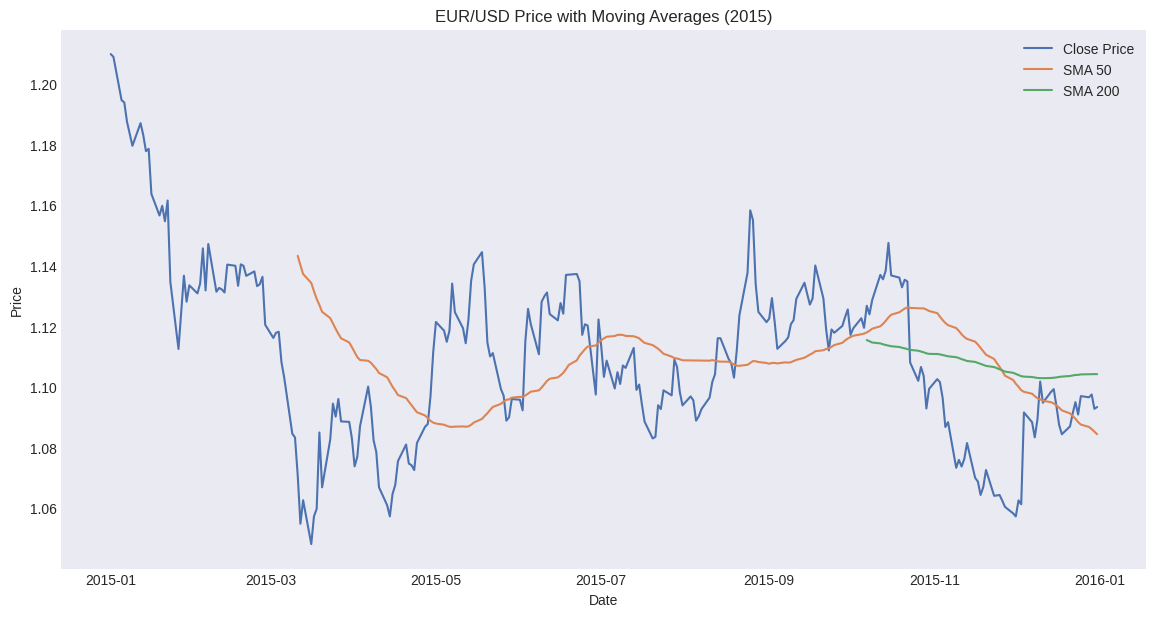

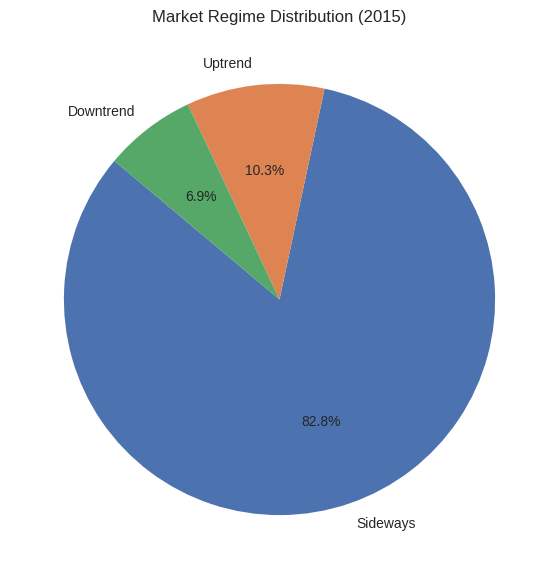

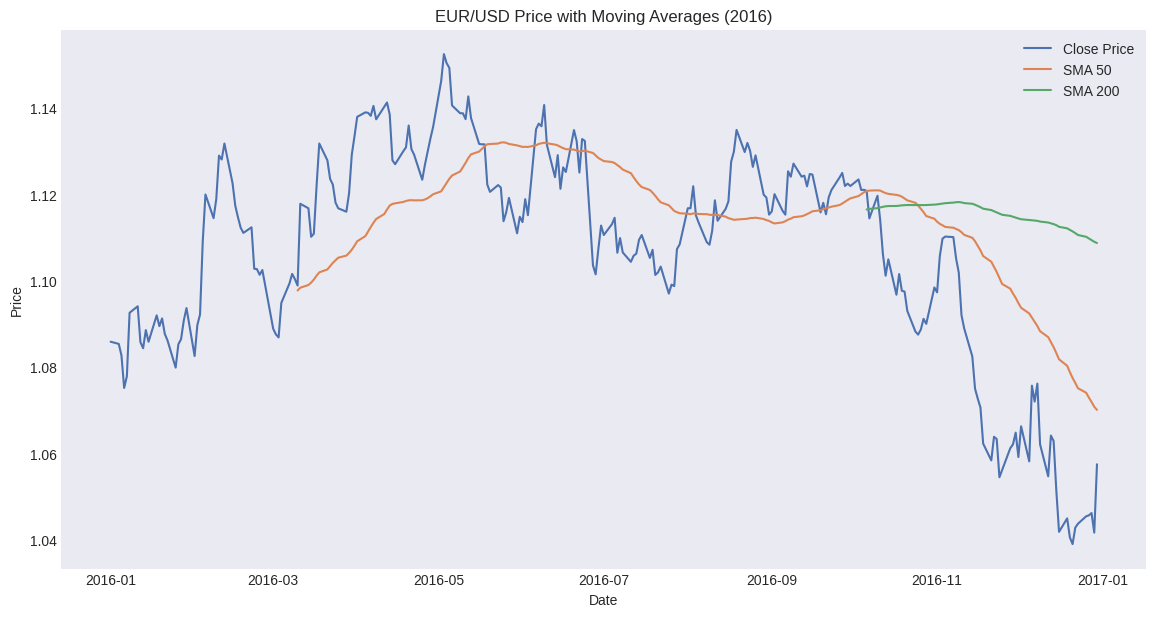

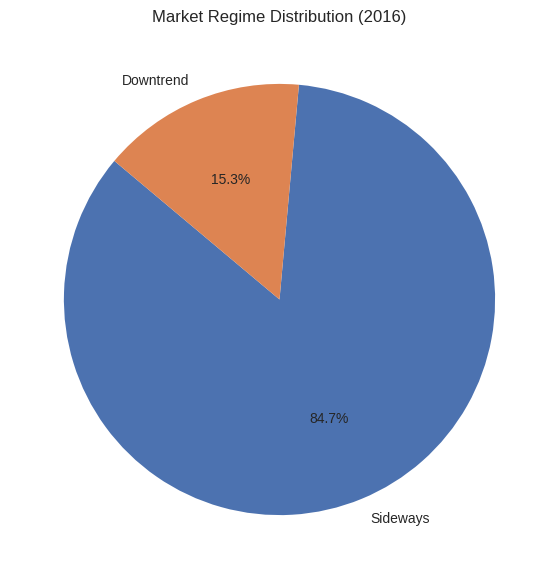

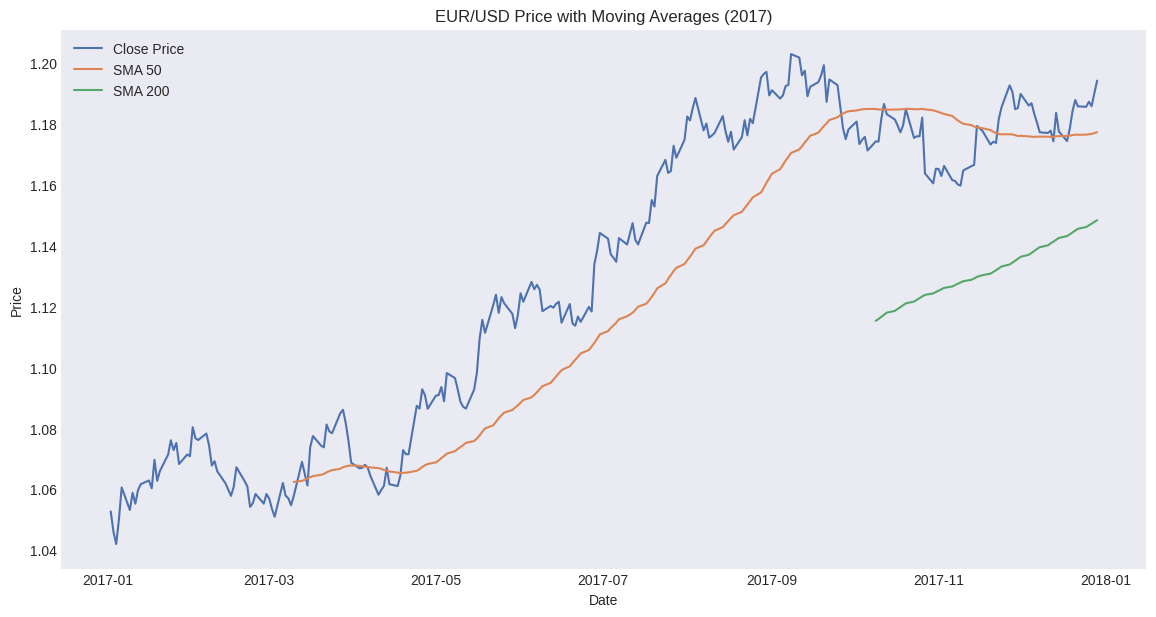

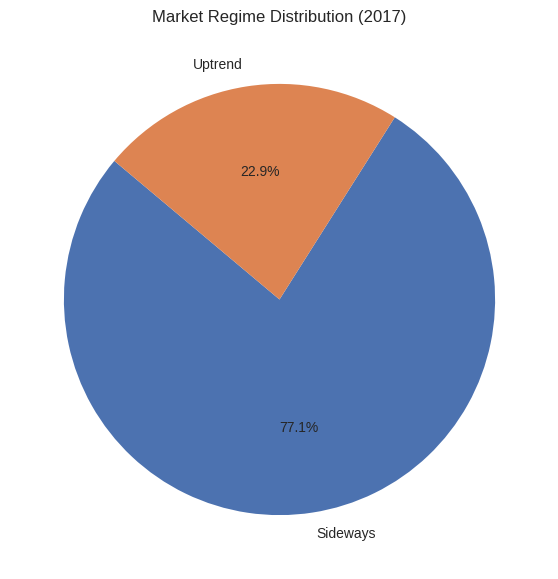

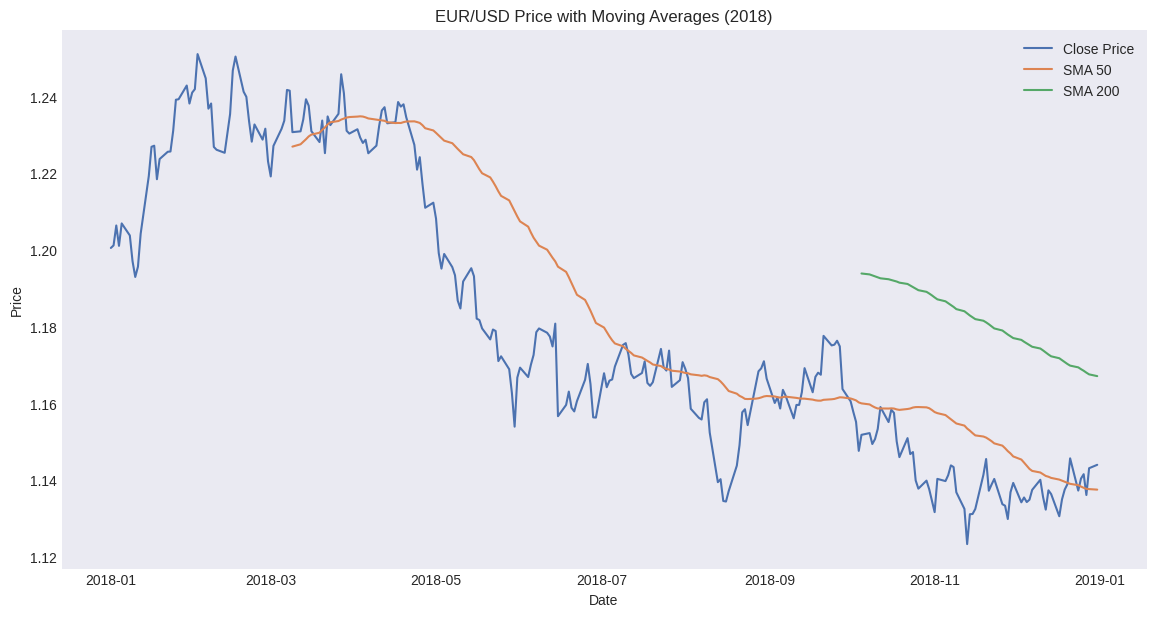

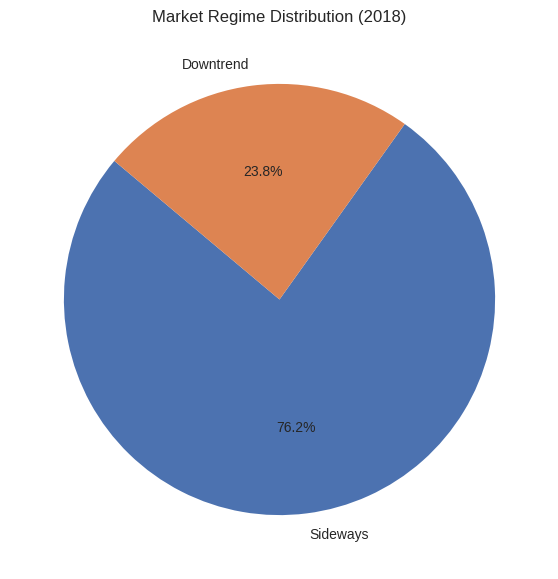

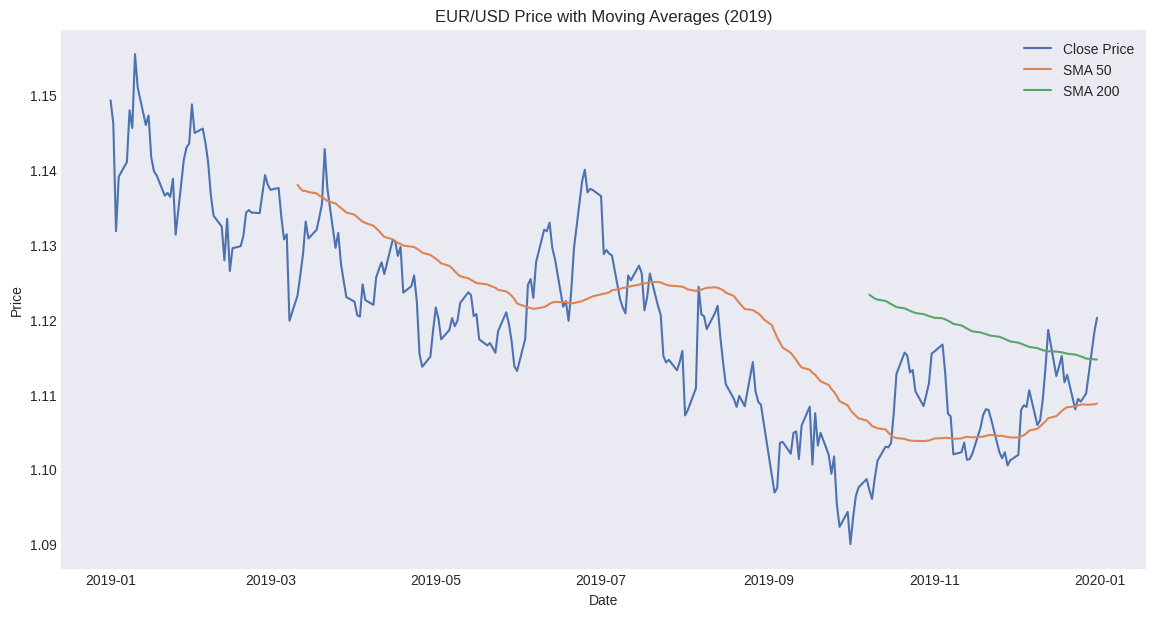

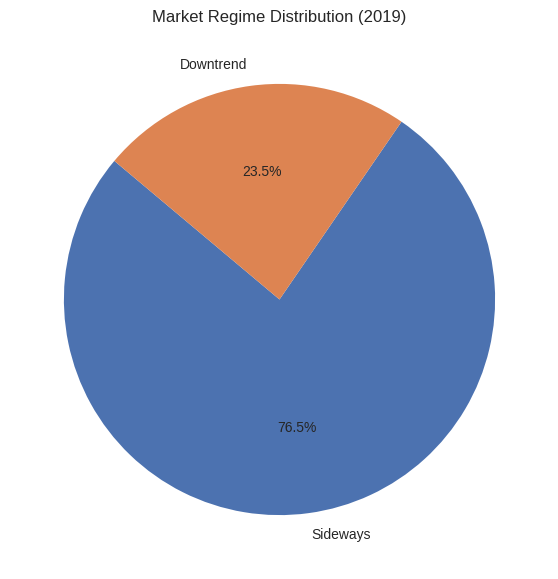

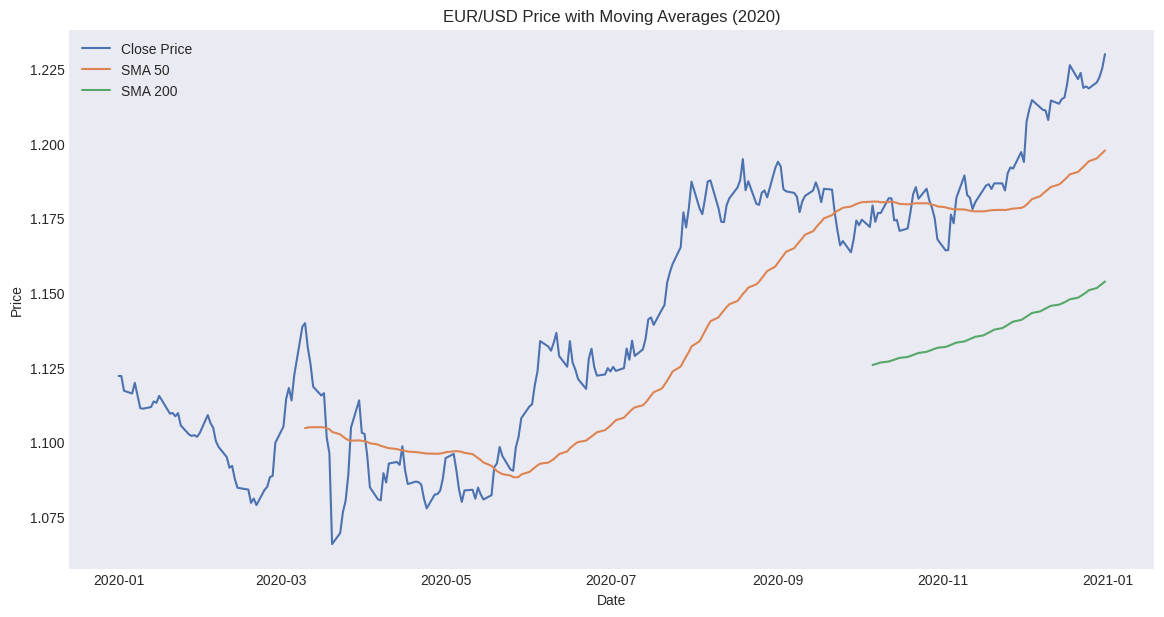

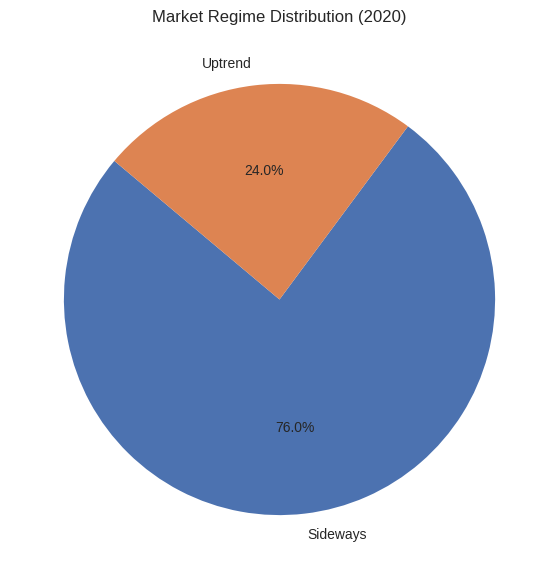

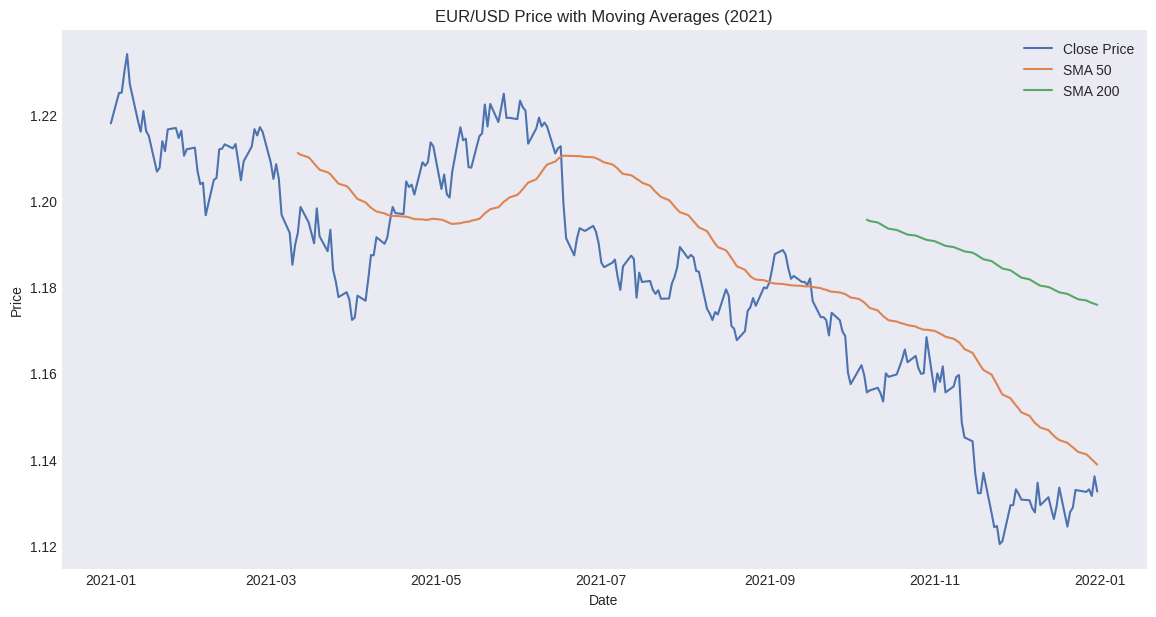

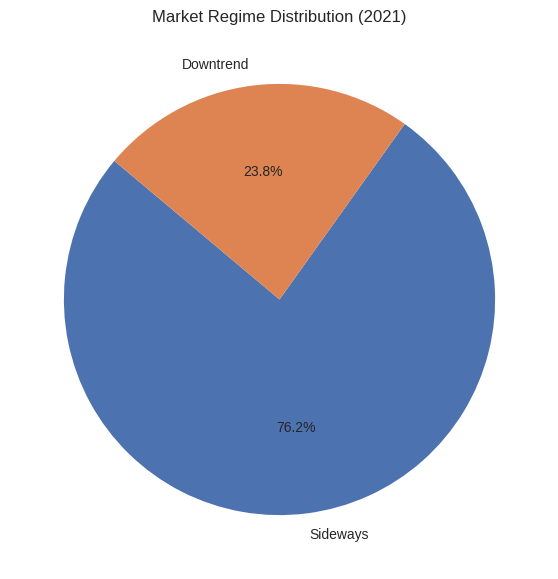

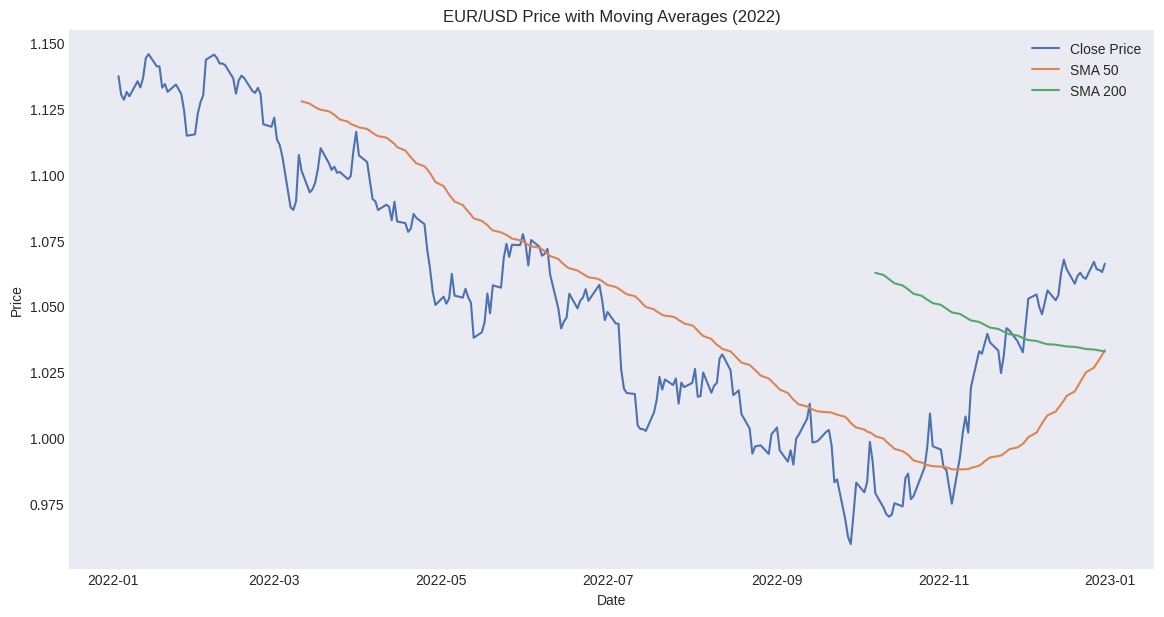

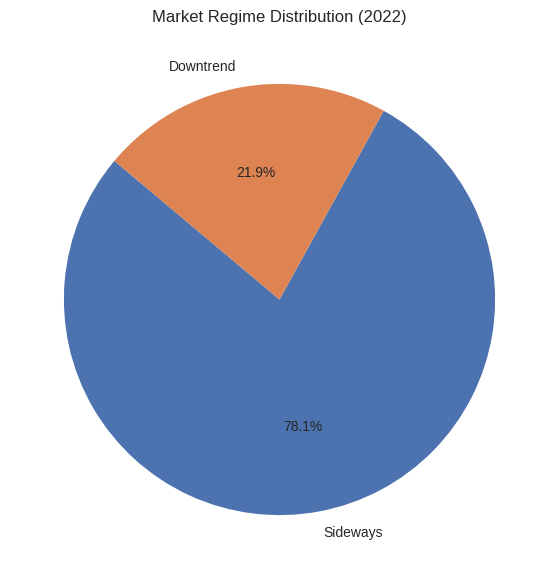

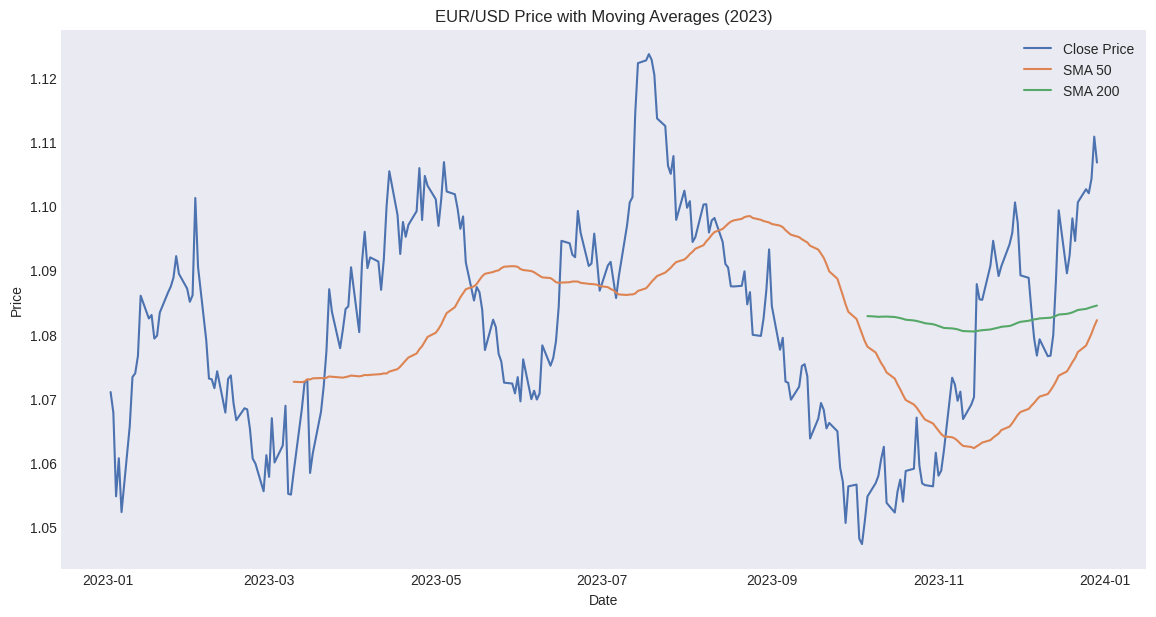

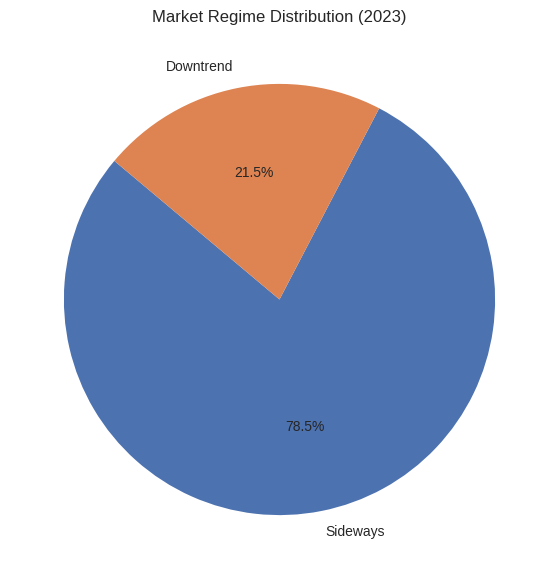


Yearly Market Regime Summary (% Time in Each Regime):
Market_Type  Downtrend  Sideways  Uptrend
2014             23.75     76.25     0.00
2015              6.90     82.76    10.34
2016             15.33     84.67     0.00
2017              0.00     77.13    22.87
2018             23.75     76.25     0.00
2019             23.46     76.54     0.00
2020              0.00     75.95    24.05
2021             23.75     76.25     0.00
2022             21.92     78.08     0.00
2023             21.54     78.46     0.00


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Download EUR/USD data (symbol: EURUSD=X)
data = yf.download('EURUSD=X', start='2014-01-01', end='2024-12-31', interval='1d')

# Basic cleaning
data = data.dropna()

# Prepare a container for summary results
yearly_summary = {}

# Loop over each year
for year in range(2014, 2024):
    yearly_data = data[(data.index >= f'{year}-01-01') & (data.index < f'{year+1}-01-01')].copy()

    if yearly_data.empty:
        continue

    yearly_data['SMA50'] = yearly_data['Close'].rolling(window=50).mean()
    yearly_data['SMA200'] = yearly_data['Close'].rolling(window=200).mean()

    high_low = yearly_data['High'] - yearly_data['Low']
    high_close = np.abs(yearly_data['High'] - yearly_data['Close'].shift())
    low_close = np.abs(yearly_data['Low'] - yearly_data['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    yearly_data['ATR14'] = true_range.rolling(window=14).mean()

    threshold = 0.005
    sma_diff = (yearly_data['SMA50'] - yearly_data['SMA200']) / yearly_data['SMA200']

    conditions = [
        sma_diff > threshold,
        sma_diff < -threshold,
        abs(sma_diff) <= threshold
    ]
    choices = ['Uptrend', 'Downtrend', 'Sideways']
    yearly_data['Market_Type'] = np.select(conditions, choices, default='Sideways')

    market_counts = yearly_data['Market_Type'].value_counts(normalize=True) * 100
    yearly_summary[year] = market_counts

    plt.figure(figsize=(14, 7))
    plt.plot(yearly_data.index, yearly_data['Close'], label='Close Price')
    plt.plot(yearly_data.index, yearly_data['SMA50'], label='SMA 50')
    plt.plot(yearly_data.index, yearly_data['SMA200'], label='SMA 200')
    plt.title(f'EUR/USD Price with Moving Averages ({year})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 7))
    plt.pie(market_counts, labels=market_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Market Regime Distribution ({year})')
    plt.show()

# Summarize all years
yearly_summary_df = pd.DataFrame(yearly_summary).T.fillna(0)
print("\nYearly Market Regime Summary (% Time in Each Regime):")
print(yearly_summary_df.round(2))


Preliminary market structure analysis shows that EUR/USD exhibits a predominantly range-bound behavior over the last 10 years.

# **Key Observations:**

* Sideways/Range-Bound Behavior: On average, 76% to 85%
of the time, the EUR/USD market remained range-bound (non-directional) across all years.
* Limited Uptrend Phases: Notable uptrends were observed only in 2015, 2017, and 2020, and even then, they were relatively limited.
* Frequent Downtrends: Some years showed moderate periods of downtrends (e.g., 2014, 2018, 2019, 2022), but they did not dominate the market behavior.

# **Conclusion and Justification for Topic Selection**

The empirical evidence clearly indicates that the EUR/USD market predominantly operates in a sideways or non-directional regime over long periods. This market behavior makes trend-following strategies less effective and validates the choice of pursuing a market-neutral approach.

Given the range-bound nature of EUR/USD:

* Long/Short Pair Trading Strategies that exploit mean-reversion characteristics are highly appropriate.
* Machine Learning and Deep Learning models can be leveraged to better predict short-term divergences between asset pairs and generate profitable long/short trade signals.
* Focusing on building a data-driven, market-neutral
trading system based on these insights ensures alignment with the real-world behavior of the asset and increases the potential for success.

Thus, our project selection — applying machine/deep learning techniques to long/short pair trading strategies — is not only theoretically justified but also grounded in a careful empirical analysis of the target market.

## Step 1: Import Libraries
This step imports all necessary libraries for data handling, analysis, machine learning, and visualization.


In [ ]:
pip install optuna

In [ ]:
# Import necessary libraries for data handling, analysis, modeling, and visualization
import pandas as pd
import numpy as np
from typing import Dict, Any, List, Tuple

# Financial Data and Statistical Analysis
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Machine Learning and Deep Learning
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Attention, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameter Optimization
import optuna

# Visualization and System
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import warnings
import time

# --- Setup Configurations ---
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')
np.random.seed(42)
tf.random.set_seed(42)

## 2. Configuration Parameters
This dictionary centralizes all strategy parameters. This design allows for easy modification, tuning, and sensitivity analysis without altering the core logic.

In [ ]:
CONFIG = {
    # Market and Data
    'markets': ['EURUSD=X'],
    'start_date': '2014-01-01',
    'end_date': '2024-12-31',

    # Feature Engineering & Fractional Differentiation
    'short_window': 50,
    'long_window': 200,
    'frac_diff_d': 0.5,
    'frac_diff_window': 252,
    'lookback': 50,
    'atr_period': 14,
    'rsi_period': 14,
    'z_score_window': 50,
    'corr_threshold': 0.85,

    # Modeling
    'autoencoder_epochs': 20,
    'autoencoder_batch_size': 64,
    'model_epochs': 20,
    'model_batch_size': 64,
    'encoding_dim': 4,

    # Strategy & Risk
    'base_entry_threshold': 1.5,
    'base_exit_threshold': 0.5,
    'hold_period': 20,
    'stop_loss': 0.05,
    'take_profit': 0.10,
    'transaction_cost': 0.0002,

    # Sizing & Exposure
    'max_position': 1.0,
    'portfolio_max_exposure': 1.5,
    'max_drawdown_threshold': 0.20,
    'kelly_fraction': 0.2,

    # Backtesting
    'test_window_size': 100,
    'n_splits': 10
}

## Step 3: Data Fetching and Custom Utility Functions
This section contains helper functions for data acquisition, custom technical indicator calculations and performance metric calculations.

In [ ]:
def get_market_data(tickers: list[str], start_date: str, end_date: str) -> dict[str, pd.DataFrame]:
    """
    Fetches and robustly cleans market data from yfinance, standardizing the DataFrame structure.
    """
    data_dict = {}
    for ticker in tickers:
        logging.info(f"Fetching data for {ticker}...")
        try:
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if data.empty:
                logging.warning(f"No data returned for {ticker}. Skipping.")
                continue

            if isinstance(data.columns, pd.MultiIndex):
                data.columns = data.columns.get_level_values(0)

            data = data.reset_index()
            data.columns = [str(col).lower().replace(' ', '_') for col in data.columns]

            required_cols = ['date', 'open', 'high', 'low', 'close']
            if not all(col in data.columns for col in required_cols):
                logging.error(f"Essential columns not found for {ticker} after cleaning. Available: {list(data.columns)}. Skipping.")
                continue

            data['date'] = pd.to_datetime(data['date'])
            data.dropna(inplace=True)
            data_dict[ticker] = data
            logging.info(f"Successfully fetched and cleaned {len(data)} rows for {ticker}.")

        except Exception as e:
            logging.error(f"An unexpected error occurred for {ticker}: {e}", exc_info=True)
            continue

    return data_dict

def get_weights_ffd(d, size):
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1] * (d - k + 1) / k
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def frac_diff(series: pd.Series, d: float, window: int) -> pd.Series:
    """Computes fractionally differentiated series using a fixed lookback window."""
    weights = get_weights_ffd(d, window)
    rolling_view = series.rolling(window=window)
    differentiated_series = rolling_view.apply(lambda x: np.dot(weights.T, x)[0], raw=True)
    return differentiated_series

def calculate_garman_klass_vol(open_p, high, low, close, window=20):
    log_hl = (high / low).apply(np.log)
    log_co = (close / open_p).apply(np.log)
    rs = 0.5 * log_hl**2 - (2 * np.log(2) - 1) * log_co**2
    vol = (rs.rolling(window).mean() * 252).apply(np.sqrt)
    return vol

# --- FIX: ADDED MISSING CUSTOM TECHNICAL INDICATOR FUNCTIONS ---
def calculate_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/period, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/period, adjust=False).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(series: pd.Series, fast: int = 12, slow: int = 26) -> pd.Series:
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    return ema_fast - ema_slow

def calculate_atr(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.ewm(alpha=1/period, adjust=False).mean()

def calculate_bollinger_bands(series: pd.Series, window: int = 20, num_std: int = 2) -> Tuple[pd.Series, pd.Series]:
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    return sma + (std * num_std), sma - (std * num_std)
# --- END OF FIX ---

def sortino_ratio(returns: pd.Series, target: float = 0, annual_factor: int = 252) -> float:
    downside_returns = returns.loc[returns < target]
    if downside_returns.empty: return 0.0
    downside_deviation = np.sqrt(np.mean(downside_returns**2)) * np.sqrt(annual_factor)
    annualized_return = returns.mean() * annual_factor
    return annualized_return / downside_deviation if downside_deviation != 0 else 0.0

def calmar_ratio(cumulative_returns: pd.Series, annual_factor: int = 252) -> float:
    if len(cumulative_returns) < 2: return 0.0
    annualized_return = (cumulative_returns.iloc[-1])**(annual_factor/len(cumulative_returns)) - 1
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / rolling_max - 1)
    max_drawdown = abs(drawdown.min())
    return annualized_return / max_drawdown if max_drawdown != 0 else 0.0

def adf_test(series: pd.Series) -> float:
    try:
        return adfuller(series.dropna())[1]
    except Exception:
        return 1.0

# --- Execute Data Fetching ---
data_dict = get_market_data(CONFIG['markets'], CONFIG['start_date'], CONFIG['end_date'])
if not data_dict or CONFIG['markets'][0] not in data_dict:
    raise RuntimeError("Failed to fetch primary market data. Halting execution.")
raw_data = data_dict[CONFIG['markets'][0]]

## Step 4. Feature Engineering Pipeline
This cell now uses the custom utility functions to generate all technical indicators.

In [ ]:
def create_moving_average_spread(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    """Create synthetic spread."""
    df = df.copy()
    df['ma_short'] = df['close'].rolling(window=config['short_window']).mean()
    df['synthetic_spread'] = df['close'] - df['ma_short']
    return df

def feature_engineering(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    """Enhanced feature engineering with custom indicator functions and fractional differentiation."""
    df = df.copy()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    for lag in range(1, 6):
        df[f'log_returns_lag{lag}'] = df['log_returns'].shift(lag)

    df['rsi'] = calculate_rsi(df['close'], period=config['rsi_period'])
    df['macd'] = calculate_macd(df['close'])
    df['bbu'], df['bbl'] = calculate_bollinger_bands(df['close'])
    df['volatility'] = calculate_garman_klass_vol(df['open'], df['high'], df['low'], df['close'], window=20)
    df['atr'] = calculate_atr(df['high'], df['low'], df['close'], period=config['atr_period'])
    df['spread_fracdiff'] = frac_diff(df['synthetic_spread'], d=config['frac_diff_d'], window=config['frac_diff_window'])

    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    logging.info(f"Feature engineering complete: {len(df)} rows")
    return df

# --- Execute Pipeline ---
data_with_spread = create_moving_average_spread(raw_data, CONFIG)
data_featured = feature_engineering(data_with_spread, CONFIG)

## Step 5: Feature Correlation Analysis & Visualization

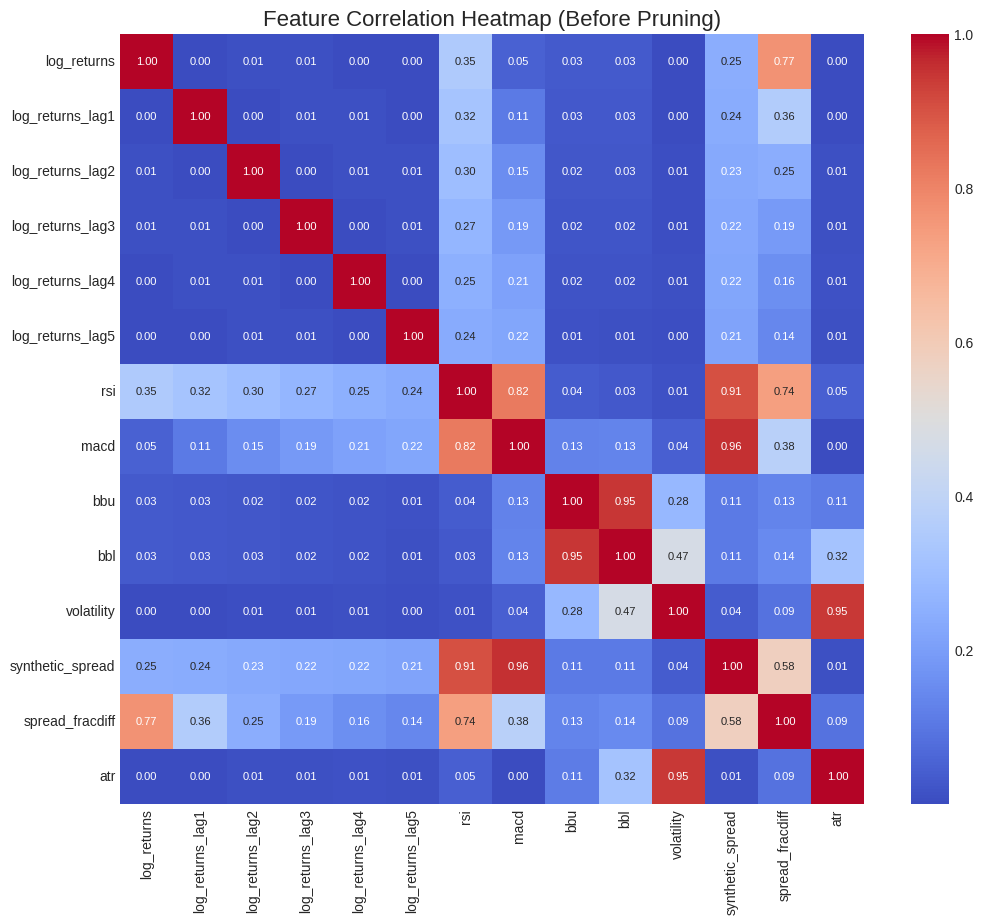

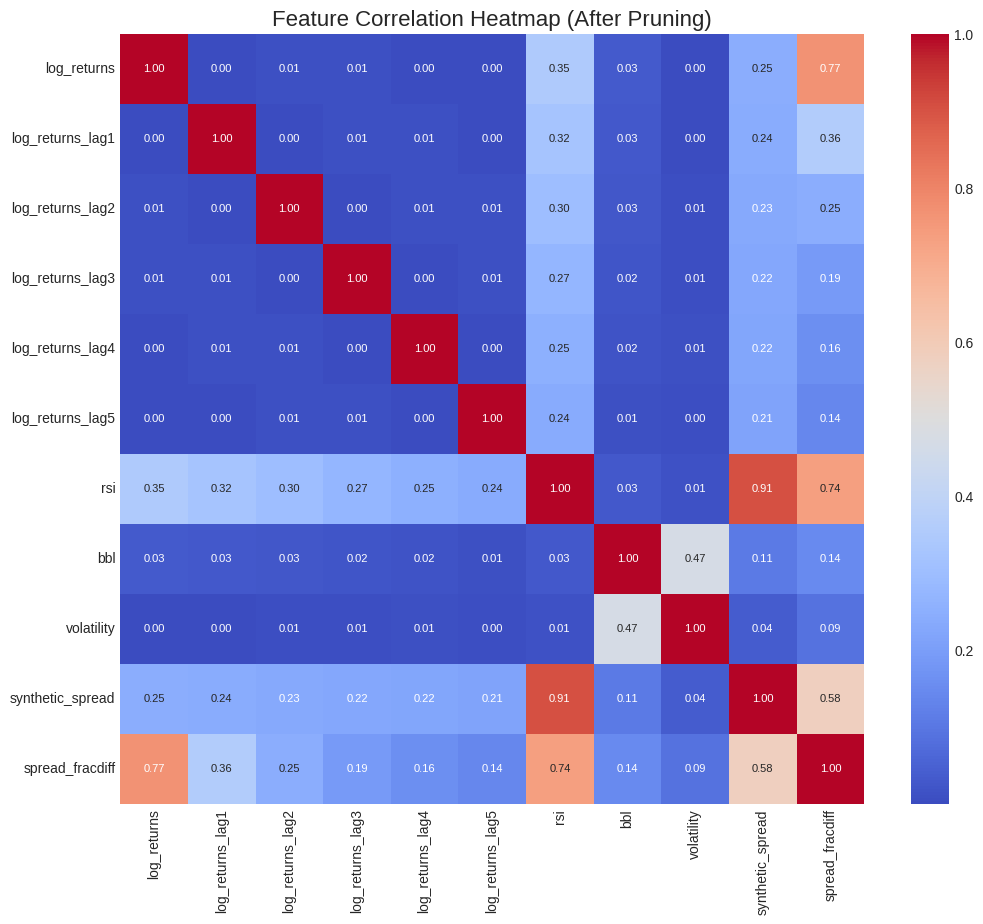

In [ ]:
def remove_highly_correlated_features(df: pd.DataFrame, config: Dict[str, Any]) -> Tuple[pd.DataFrame, List[str]]:
    """Analyze and remove features with correlation above a threshold."""
    # --- FIX: Ensure ALL generated features are in this list for analysis ---
    features = [f for f in [
        'log_returns', 'log_returns_lag1', 'log_returns_lag2', 'log_returns_lag3',
        'log_returns_lag4', 'log_returns_lag5', 'rsi', 'macd',
        'bbu', 'bbl', 'volatility', 'synthetic_spread',
        'spread_fracdiff', 'atr'
    ] if f in df.columns]

    corr_matrix = df[features].corr().abs()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})
    plt.title('Feature Correlation Heatmap (Before Pruning)', fontsize=16)
    plt.show()

    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > config['corr_threshold']:
                colname_i = corr_matrix.columns[i]
                colname_j = corr_matrix.columns[j]
                if df[colname_i].var() < df[colname_j].var():
                    to_drop.add(colname_i)
                else:
                    to_drop.add(colname_j)

    to_drop.discard('synthetic_spread')
    to_drop.discard('spread_fracdiff')

    kept_features = [f for f in features if f not in to_drop]
    logging.info(f"Features kept for modeling: {kept_features}")

    plt.figure(figsize=(12, 10))
    sns.heatmap(df[kept_features].corr().abs(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})
    plt.title('Feature Correlation Heatmap (After Pruning)', fontsize=16)
    plt.show()

    return df, kept_features

# --- Execute Correlation Analysis ---
data_final, selected_features = remove_highly_correlated_features(data_featured, CONFIG)

## Step 6: Spread Stationarity Analysis & Visualization

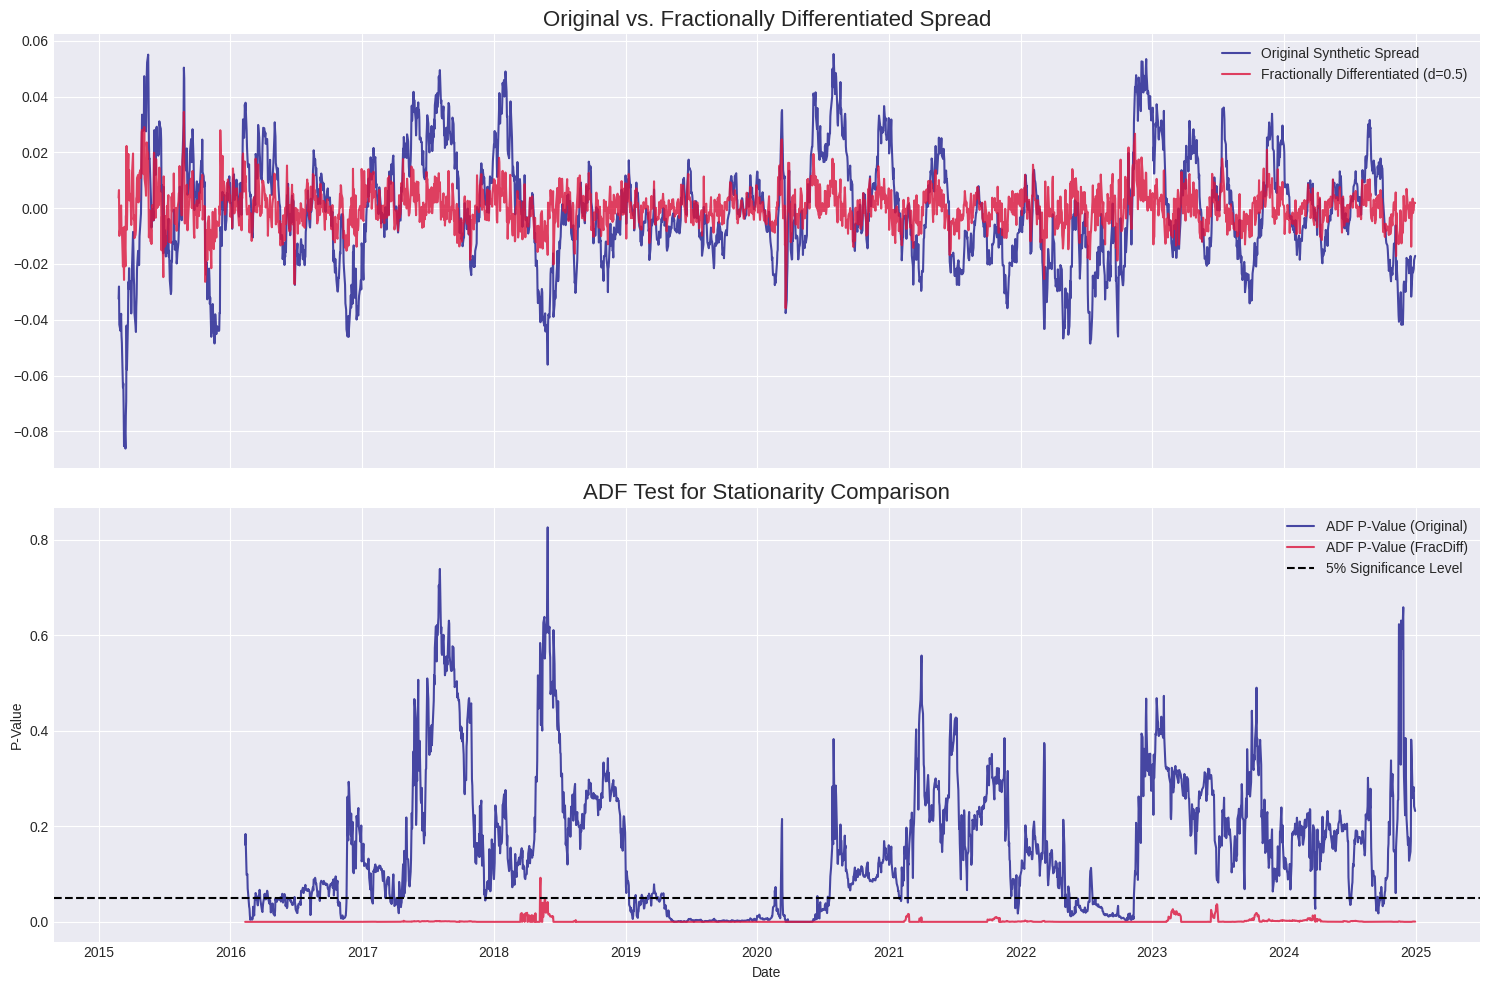

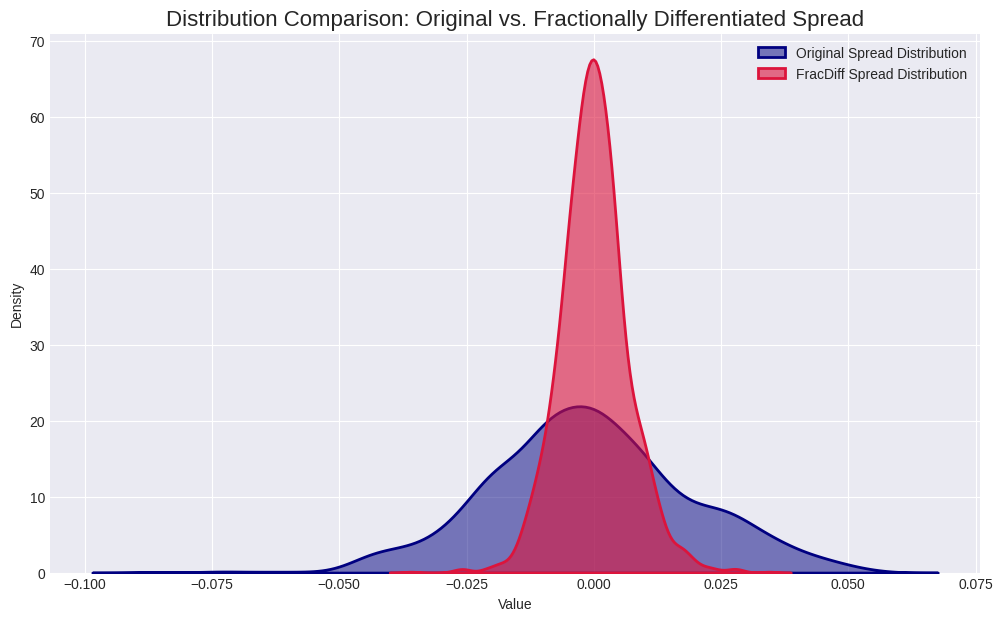

In [ ]:
def visualize_fractional_differentiation(df: pd.DataFrame, config: Dict[str, Any]):
    """Visualize the effect of fractional differentiation, including distribution comparison."""
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    axs[0].plot(df['date'], df['synthetic_spread'], label='Original Synthetic Spread', color='navy', alpha=0.7)
    axs[0].plot(df['date'], df['spread_fracdiff'], label=f"Fractionally Differentiated (d={config['frac_diff_d']})", color='crimson', alpha=0.8)
    axs[0].set_title('Original vs. Fractionally Differentiated Spread', fontsize=16)
    axs[0].legend(); axs[0].grid(True)

    original_adf = df['synthetic_spread'].rolling(window=252).apply(adf_test, raw=False)
    fracdiff_adf = df['spread_fracdiff'].rolling(window=252).apply(adf_test, raw=False)

    axs[1].plot(df['date'], original_adf, label='ADF P-Value (Original)', color='navy', alpha=0.7)
    axs[1].plot(df['date'], fracdiff_adf, label='ADF P-Value (FracDiff)', color='crimson', alpha=0.8)
    axs[1].axhline(y=0.05, color='black', linestyle='--', label='5% Significance Level')
    axs[1].set_title('ADF Test for Stationarity Comparison', fontsize=16)
    axs[1].set_xlabel('Date'); axs[1].set_ylabel('P-Value'); axs[1].legend(); axs[1].grid(True)

    plt.tight_layout(); plt.show()

    plt.figure(figsize=(12, 7))
    sns.kdeplot(df['synthetic_spread'], label='Original Spread Distribution', color='navy', fill=True, alpha=0.5, lw=2)
    sns.kdeplot(df['spread_fracdiff'], label='FracDiff Spread Distribution', color='crimson', fill=True, alpha=0.6, lw=2)
    plt.title('Distribution Comparison: Original vs. Fractionally Differentiated Spread', fontsize=16)
    plt.xlabel('Value'); plt.ylabel('Density'); plt.legend(); plt.grid(True)
    plt.show()

visualize_fractional_differentiation(data_final, CONFIG)

A critical prerequisite for a successful mean-reversion strategy is the stationarity of the variable being traded. Our initial analysis revealed that the raw "synthetic spread" (close - 50-day MA) exhibited significant non-stationary characteristics, making it an unreliable target for prediction. To address this, we employed the technique of fractional differentiation (with a parameter of d=0.5) to transform the series.

The efficacy of this transformation is immediately apparent through visual and statistical inspection.

While the original spread's time series displays pronounced trends and high-amplitude fluctuations, the fractionally differentiated series is markedly more stable, with its variations tightly centered around a zero mean. This visual finding is statistically corroborated by the rolling Augmented Dickey-Fuller (ADF) tests. The p-value of the original spread frequently breached the 0.05 significance threshold, formally indicating periods of non-stationarity. In contrast, the p-value for the differentiated series remains consistently and decisively below this critical threshold, providing strong evidence of its stationarity.

Furthermore, a comparison of their respective distributions underscores the success of the transformation. The original spread’s distribution is wide and dispersed, reflecting its volatile and trending nature. The fractionally differentiated spread, however, exhibits a sharp, narrow distribution highly concentrated at zero—the hallmark of a stationary, mean-reverting process.

Therefore, the use of this fractionally differentiated spread as the primary predictive target provides a statistically robust and reliable foundation for the subsequent modeling efforts.

## Step 7: Model & Objective Function Definitions

In [ ]:
# --- Model Architectures ---
def create_lstm_model(input_shape: Tuple[int, int], units: int, learning_rate: float) -> Sequential:
    """Create a standard LSTM model."""
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(units // 2),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    return model

def create_lstm_attention_model(input_shape: Tuple[int, int], units: int, learning_rate: float) -> Model:
    """Create LSTM model with Attention mechanism."""
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(units, return_sequences=True)(inputs)
    lstm_out = Dropout(0.3)(lstm_out)

    attention_out = Attention()([lstm_out, lstm_out])
    context_vector = Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(attention_out)

    dense_out = Dense(units // 2, activation='relu')(context_vector)
    outputs = Dense(1)(dense_out)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    return model

def create_cnn_lstm_attention_model(input_shape: Tuple[int, int], filters: int, kernel_size: int, lstm_units: int, learning_rate: float) -> Model:
    """Create a hybrid CNN-LSTM model with an Attention mechanism."""
    inputs = Input(shape=input_shape)
    conv_out = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='causal')(inputs)
    conv_out = MaxPooling1D(pool_size=2)(conv_out)
    conv_out = Dropout(0.3)(conv_out)

    lstm_out = LSTM(lstm_units, return_sequences=True)(conv_out)

    attention_out = Attention()([lstm_out, lstm_out])
    context_vector = Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(attention_out)

    outputs = Dense(1)(context_vector)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
    return model

def create_autoencoder(input_shape: Tuple[int, int], lstm_units: int, encoding_dim: int) -> Model:
    """Create LSTM autoencoder for anomaly detection."""
    inputs = Input(shape=input_shape)
    encoded = LSTM(lstm_units, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(encoding_dim, activation='relu', return_sequences=False)(encoded)
    decoded = RepeatVector(input_shape[0])(encoded)
    decoded = LSTM(encoding_dim, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(lstm_units, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(input_shape[1]))(decoded)
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

def ols_model(X: np.ndarray, y: np.ndarray):
    """Fit OLS model with a constant."""
    return sm.OLS(y, sm.add_constant(X)).fit()

# --- Optuna Objectives ---
def objective_lstm(trial, X_train, y_train, config):
    units = trial.suggest_int('units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    model = create_lstm_model((config['lookback'], X_train.shape[1]), units, learning_rate)
    X_train_seq = np.array([X_train[i:i+config['lookback']] for i in range(len(X_train) - config['lookback'])])
    y_train_seq = y_train[config['lookback']:]
    history = model.fit(X_train_seq, y_train_seq, epochs=config['model_epochs'], batch_size=config['model_batch_size'], validation_split=0.2, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    return history.history['val_loss'][-1]

def objective_lstm_attention(trial, X_train, y_train, config):
    units = trial.suggest_int('units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    model = create_lstm_attention_model((config['lookback'], X_train.shape[1]), units, learning_rate)
    X_train_seq = np.array([X_train[i:i+config['lookback']] for i in range(len(X_train) - config['lookback'])])
    y_train_seq = y_train[config['lookback']:]
    history = model.fit(X_train_seq, y_train_seq, epochs=config['model_epochs'], batch_size=config['model_batch_size'], validation_split=0.2, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    return history.history['val_loss'][-1]

def objective_cnn_lstm_attention(trial, X_train, y_train, config):
    filters = trial.suggest_int('filters', 16, 64)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    model = create_cnn_lstm_attention_model((config['lookback'], X_train.shape[1]), filters, kernel_size, lstm_units, learning_rate)
    X_train_seq = np.array([X_train[i:i+config['lookback']] for i in range(len(X_train) - config['lookback'])])
    y_train_seq = y_train[config['lookback']:]
    history = model.fit(X_train_seq, y_train_seq, epochs=config['model_epochs'], batch_size=config['model_batch_size'], validation_split=0.2, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    return model.history.history['val_loss'][-1]

def objective_random_forest(trial, X_train, y_train):
    params = {'n_estimators': trial.suggest_int('n_estimators', 50, 300), 'max_depth': trial.suggest_int('max_depth', 5, 20)}
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    score = -np.mean(cross_val_score(model, X_train, y_train, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error'))
    return score

def objective_xgboost(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300), 'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
    }
    model = XGBRegressor(**params, random_state=42, n_jobs=-1)
    score = -np.mean(cross_val_score(model, X_train, y_train, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error'))
    return score

def objective_autoencoder(trial, X_seq, config):
    lstm_units = trial.suggest_int('lstm_units', 16, 64)
    encoding_dim = trial.suggest_int('encoding_dim', 2, 16)
    autoencoder = create_autoencoder((config['lookback'], X_seq.shape[2]), lstm_units, encoding_dim)
    autoencoder.fit(X_seq, X_seq, epochs=config['autoencoder_epochs'], batch_size=config['autoencoder_batch_size'], validation_split=0.2, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    return autoencoder.history.history['val_loss'][-1]

## Step 8: One-Time Hyperparameter Tuning

In [ ]:
def tune_all_models(df: pd.DataFrame, config: Dict[str, Any], features: List[str], n_trials: int = 15) -> Dict[str, Dict[str, Any]]:
    """Performs a robust, one-time hyperparameter tuning for all models on the initial training set."""
    logging.info("--- Starting One-Time Hyperparameter Tuning ---")

    initial_train_size = int(len(df) * 0.5)
    train_data = df.iloc[:initial_train_size]

    X_train = train_data[features].values
    y_train = train_data['spread_fracdiff'].values

    best_params_all_models = {}

    models_to_tune = {
        "lstm": objective_lstm,
        "lstm_attention": objective_lstm_attention,
        "cnn_lstm_attention": objective_cnn_lstm_attention,
        "rf": objective_random_forest,
        "xgb": objective_xgboost
    }

    for name, objective_func in models_to_tune.items():
        logging.info(f"Tuning {name.upper()} model...")
        study = optuna.create_study(direction='minimize')
        if "lstm" in name:
            study.optimize(lambda trial: objective_func(trial, RobustScaler().fit_transform(X_train), y_train, config), n_trials=n_trials)
        else:
            study.optimize(lambda trial: objective_func(trial, X_train, y_train), n_trials=n_trials)
        best_params_all_models[name] = study.best_params
        logging.info(f"Best params for {name.upper()}: {study.best_params}")

    logging.info("Tuning LSTM Autoencoder...")
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_seq = np.array([X_train_scaled[i:i + config['lookback']] for i in range(len(X_train_scaled) - config['lookback'])])

    study_autoencoder = optuna.create_study(direction='minimize')
    study_autoencoder.optimize(lambda trial: objective_autoencoder(trial, X_train_seq, config), n_trials=n_trials)
    best_params_all_models['autoencoder'] = study_autoencoder.best_params
    logging.info(f"Best params for Autoencoder: {study_autoencoder.best_params}")

    return best_params_all_models

# --- Define feature list for models ---
final_features = [f for f in selected_features if f not in ['synthetic_spread', 'spread_fracdiff']]

# --- Execute Tuning ---
tuned_hyperparams = tune_all_models(data_final, CONFIG, final_features, n_trials=20)

[I 2025-06-11 06:07:27,255] A new study created in memory with name: no-name-a4c784aa-86be-48e9-aa6a-15053e987746
[I 2025-06-11 06:08:06,829] Trial 0 finished with value: 1.426830294803949e-05 and parameters: {'units': 92, 'learning_rate': 0.002730024635088743}. Best is trial 0 with value: 1.426830294803949e-05.
[I 2025-06-11 06:08:53,043] Trial 1 finished with value: 1.7785030649974942e-05 and parameters: {'units': 119, 'learning_rate': 0.003984215857527736}. Best is trial 0 with value: 1.426830294803949e-05.
[I 2025-06-11 06:09:14,687] Trial 2 finished with value: 6.836144166300073e-05 and parameters: {'units': 124, 'learning_rate': 0.004692204875892668}. Best is trial 0 with value: 1.426830294803949e-05.
[I 2025-06-11 06:09:41,932] Trial 3 finished with value: 3.381193891982548e-05 and parameters: {'units': 115, 'learning_rate': 0.0015100382369724564}. Best is trial 0 with value: 1.426830294803949e-05.
[I 2025-06-11 06:10:02,803] Trial 4 finished with value: 5.125050665810704e-05 an

## Step 9: Signal, Risk, and Backtesting Pipeline

In [ ]:
# --- All Helper Functions Are Defined First to Prevent NameError ---

def evaluate_performance(df: pd.DataFrame) -> Dict[str, float]:
    """Compute strategy performance metrics."""
    returns = df['strategy_returns'].fillna(0)
    cumulative_returns = df['cumulative_returns'].fillna(1)

    if len(cumulative_returns) < 2 or returns.std() == 0:
        return {'Cumulative Return': 0, 'Sharpe Ratio': 0, 'Sortino Ratio': 0, 'Calmar Ratio': 0, 'Max Drawdown': 0}

    sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() != 0 else 0
    sortino = sortino_ratio(returns)
    calmar = calmar_ratio(cumulative_returns)
    max_drawdown = (1 - cumulative_returns / cumulative_returns.cummax()).max()
    cumulative_return = cumulative_returns.iloc[-1] - 1 if not cumulative_returns.empty else 0

    return {
        'Cumulative Return': cumulative_return, 'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino, 'Calmar Ratio': calmar, 'Max Drawdown': -max_drawdown
    }

def generate_signals(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    """Generate trading signals with DYNAMIC thresholds and RSI momentum filter."""
    df = df.copy()

    vol_factor = (df['volatility'] / df['volatility'].rolling(window=50).mean()).fillna(1)
    df['dynamic_entry_threshold'] = config['base_entry_threshold'] * vol_factor.clip(0.8, 1.5)

    df['predicted_z_score'] = (df['predicted_spread'] - df['predicted_spread'].rolling(window=config['z_score_window']).mean()) / \
                              df['predicted_spread'].rolling(window=config['z_score_window']).std()

    df['signal'] = 0
    df.loc[(df['predicted_z_score'] > df['dynamic_entry_threshold']) & (df['rsi'] > 65), 'signal'] = -1
    df.loc[(df['predicted_z_score'] < -df['dynamic_entry_threshold']) & (df['rsi'] < 35), 'signal'] = 1

    df['signal'] = df['signal'].replace(0, np.nan).ffill().fillna(0)

    exit_condition = (df['signal'].shift(1) == 1) & (df['predicted_z_score'] > -config['base_exit_threshold']) | \
                     (df['signal'].shift(1) == -1) & (df['predicted_z_score'] < config['base_exit_threshold'])

    df.loc[exit_condition, 'signal'] = 0
    df['signal'] = df['signal'].replace(0, np.nan).ffill().fillna(0)

    return df

def apply_risk_management(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    """Apply comprehensive risk management pipeline."""
    df = df.copy()
    assert 'atr' in df.columns, "DataFrame passed to risk management is missing the 'atr' column."

    df['atr_factor'] = (df['atr'] / df['atr'].rolling(window=50).mean()).fillna(1)
    df['position'] = df['signal'].shift(1).fillna(0) * (1 / df['atr_factor'].clip(lower=0.5, upper=2.0))
    df['position'] = df['position'].clip(lower=-config['max_position'], upper=config['max_position'])

    vol_25 = df['volatility'].rolling(window=50).quantile(0.25)
    vol_75 = df['volatility'].rolling(window=50).quantile(0.75)
    df['position'] *= np.where(df['volatility'] < vol_25, 1.5, np.where(df['volatility'] > vol_75, 0.8, 1.0))

    if 'reconstruction_error' in df.columns and not df['reconstruction_error'].isnull().all():
        rolling_vol = df['volatility'].rolling(window=50).mean().fillna(df['volatility'].mean())
        base_threshold = np.percentile(df['reconstruction_error'].dropna(), 99)
        anomaly_threshold = base_threshold * (1 + (df['volatility'] / rolling_vol - 1).clip(lower=-0.2, upper=0.2))
        df.loc[df['reconstruction_error'] > anomaly_threshold, 'position'] = 0

    df['corr'] = df['close'].rolling(window=50).corr(df['synthetic_spread']).fillna(0)
    df.loc[abs(df['corr']) > config['corr_threshold'], 'position'] = 0

    df['position'] *= config['kelly_fraction']
    df['position'] = df['position'].clip(lower=-config['portfolio_max_exposure'], upper=config['portfolio_max_exposure'])

    df['spread_change'] = df['synthetic_spread'].diff().fillna(0)
    df['strategy_returns'] = (df['log_returns'].fillna(0) - df['spread_change']) * df['position'].shift(1).fillna(0)
    df['strategy_returns'] -= abs(df['position'].diff().fillna(0)) * config['transaction_cost']
    df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()

    return df

## Step 10:Walk-Forward Validation & Execution

In [ ]:
def predict_model(model_name: str, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray,
                  X_train_seq: np.ndarray, y_train_seq: np.ndarray, X_test_seq: np.ndarray,
                  config: Dict[str, Any], best_params: Dict[str, Any]) -> np.ndarray:
    """Train model and predict using pre-tuned hyperparameters."""
    num_features = X_train.shape[1]
    try:
        # --- UPDATED: Includes all 6 models ---
        if model_name == 'lstm':
            model = create_lstm_model((config['lookback'], num_features), best_params['lstm']['units'], best_params['lstm']['learning_rate'])
            model.fit(X_train_seq, y_train_seq, epochs=config['model_epochs'], batch_size=config['model_batch_size'], verbose=0, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])
            return model.predict(X_test_seq, verbose=0).flatten()
        elif model_name == 'lstm_attention':
            model = create_lstm_attention_model((config['lookback'], num_features), best_params['lstm_attention']['units'], best_params['lstm_attention']['learning_rate'])
            model.fit(X_train_seq, y_train_seq, epochs=config['model_epochs'], batch_size=config['model_batch_size'], verbose=0, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])
            return model.predict(X_test_seq, verbose=0).flatten()
        elif model_name == 'cnn_lstm_attention':
            model = create_cnn_lstm_attention_model((config['lookback'], num_features), best_params['cnn_lstm_attention']['filters'], best_params['cnn_lstm_attention']['kernel_size'], best_params['cnn_lstm_attention']['lstm_units'], best_params['cnn_lstm_attention']['learning_rate'])
            model.fit(X_train_seq, y_train_seq, epochs=config['model_epochs'], batch_size=config['model_batch_size'], verbose=0, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])
            return model.predict(X_test_seq, verbose=0).flatten()
        elif model_name == 'rf':
            model = RandomForestRegressor(**best_params['rf'], random_state=42, n_jobs=-1)
            model.fit(X_train, y_train)
            return model.predict(X_test)
        elif model_name == 'xgb':
            model = XGBRegressor(**best_params['xgb'], random_state=42, n_jobs=-1)
            model.fit(X_train, y_train)
            return model.predict(X_test)
        elif model_name == 'ols':
            model = ols_model(X_train, y_train)
            return model.predict(sm.add_constant(X_test))
    except Exception as e:
        logging.error(f"Prediction error for {model_name}: {e}")
        return np.zeros(len(X_test))

def walk_forward_validation(df: pd.DataFrame, config: Dict[str, Any], features: List[str], best_params: Dict[str, Any]) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """Final walk-forward validation with full 6-model ensemble."""
    df = df.copy()
    tscv = TimeSeriesSplit(n_splits=config['n_splits'], test_size=config['test_window_size'])

    all_results = []
    # --- UPDATED: Includes all 6 models ---
    model_names = ['lstm', 'lstm_attention', 'cnn_lstm_attention', 'rf', 'xgb', 'ols']
    model_weights = {m: 1.0 / len(model_names) for m in model_names}
    historical_metrics = {metric: {m: [] for m in model_names + ['ensemble']} for metric in ['sharpe', 'mae', 'rmse', 'r2']}

    for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
        try:
            logging.info(f"--- Processing Fold {fold + 1}/{tscv.n_splits} ---")
            train_data, test_data = df.iloc[train_idx], df.iloc[test_idx].copy()

            X_train, y_train = train_data[features].values, train_data['spread_fracdiff'].values
            X_test, y_test = test_data[features].values, test_data['spread_fracdiff'].values

            scaler = RobustScaler().fit(X_train)
            X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

            X_train_seq = np.array([X_train_scaled[i:i+config['lookback']] for i in range(len(X_train_scaled) - config['lookback'])])
            y_train_seq = y_train[config['lookback']:]
            X_test_seq = np.array([X_test_scaled[i:i+config['lookback']] for i in range(len(X_test_scaled) - config['lookback'])])

            if X_test_seq.shape[0] == 0: continue

            autoencoder = create_autoencoder((config['lookback'], len(features)), best_params['autoencoder']['lstm_units'], best_params['autoencoder']['encoding_dim'])
            autoencoder.fit(X_train_seq, X_train_seq, epochs=config['autoencoder_epochs'], validation_split=0.2, verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
            recon_error = np.mean(np.square(X_test_seq - autoencoder.predict(X_test_seq, verbose=0)), axis=(1, 2))
            test_data.loc[test_data.index[-len(recon_error):], 'reconstruction_error'] = recon_error

            predictions_df = pd.DataFrame(index=test_data.index)
            for name in model_names:
                preds = predict_model(name, X_train, y_train, X_test, X_train_seq, y_train_seq, X_test_seq, config, best_params)
                if 'lstm' in name:
                    pred_indices = test_data.index[config['lookback']:]
                    if len(pred_indices) == len(preds): predictions_df.loc[pred_indices, name] = preds
                else:
                    predictions_df[name] = preds

            if fold > 2:
                mae_inv = {m: 1 / (np.mean(historical_metrics['mae'][m][-3:]) + 1e-10) for m in model_names if historical_metrics['mae'][m]}
                if mae_inv:
                    total_inv_mae = sum(mae_inv.values())
                    model_weights = {m: mae_inv.get(m, 0) / total_inv_mae if total_inv_mae > 0 else 1/len(model_names) for m in model_names}

            predictions_df['ensemble'] = predictions_df[model_names].mul(model_weights).sum(axis=1)

            for model_name in model_names + ['ensemble']:
                test_data_model = test_data.copy()
                test_data_model['predicted_spread'] = predictions_df[model_name]
                test_data_model.dropna(subset=['predicted_spread'], inplace=True)
                if test_data_model.empty: continue

                y_true = test_data_model['spread_fracdiff'].values
                y_pred = test_data_model['predicted_spread'].values

                historical_metrics['mae'][model_name].append(mean_absolute_error(y_true, y_pred))
                historical_metrics['rmse'][model_name].append(np.sqrt(mean_squared_error(y_true, y_pred)))
                historical_metrics['r2'][model_name].append(r2_score(y_true, y_pred))

                signals_df = generate_signals(test_data_model, config)
                results_df = apply_risk_management(signals_df, config)
                perf = evaluate_performance(results_df)
                historical_metrics['sharpe'][model_name].append(perf['Sharpe Ratio'])
                all_results.append(results_df.assign(Model=model_name))

        except Exception as e:
            logging.error(f"An error occurred in fold {fold + 1}, skipping. Error: {e}", exc_info=True)
            continue

    if not all_results:
        raise RuntimeError("Backtest produced no results. Check logs for errors in all folds.")

    final_results_df = pd.concat(all_results, ignore_index=True)
    ensemble_df = final_results_df[final_results_df['Model'] == 'ensemble'].copy()
    models_df = final_results_df[final_results_df['Model'] != 'ensemble'].copy()

    return ensemble_df, models_df, historical_metrics

# --- Execute Backtest ---
from sklearn.metrics import r2_score
final_ensemble_df, final_models_df, historical_metrics = walk_forward_validation(data_final, CONFIG, final_features, tuned_hyperparams)

## Step 11: Final Performance Analysis, Comparison, & Visualization

--- Model Predictive Power Analysis ---
| Model              |   Avg MAE |   Avg RMSE |   Avg R-Squared |   Std Dev (R-Squared) |
|:-------------------|----------:|-----------:|----------------:|----------------------:|
| OLS                |    0.0015 |     0.0018 |          0.896  |                0.0825 |
| XGB                |    0.0016 |     0.0019 |          0.8919 |                0.0622 |
| RF                 |    0.0017 |     0.002  |          0.8816 |                0.0589 |
| LSTM               |    0.0041 |     0.0053 |          0.028  |                0.1623 |
| ENSEMBLE           |    0.0065 |     0.0091 |        -11.5474 |               32.1661 |
| CNN_LSTM_ATTENTION |    0.0427 |     0.0524 |       -148.137  |              209.094  |
| LSTM_ATTENTION     |    0.1741 |     0.1978 |      -1750.05   |             2023.36   |

--- Strategy Financial Performance Comparison ---
| Model              |   Cumulative Return (%) |   Sharpe Ratio |   Sortino Ratio |   Calmar Ratio 

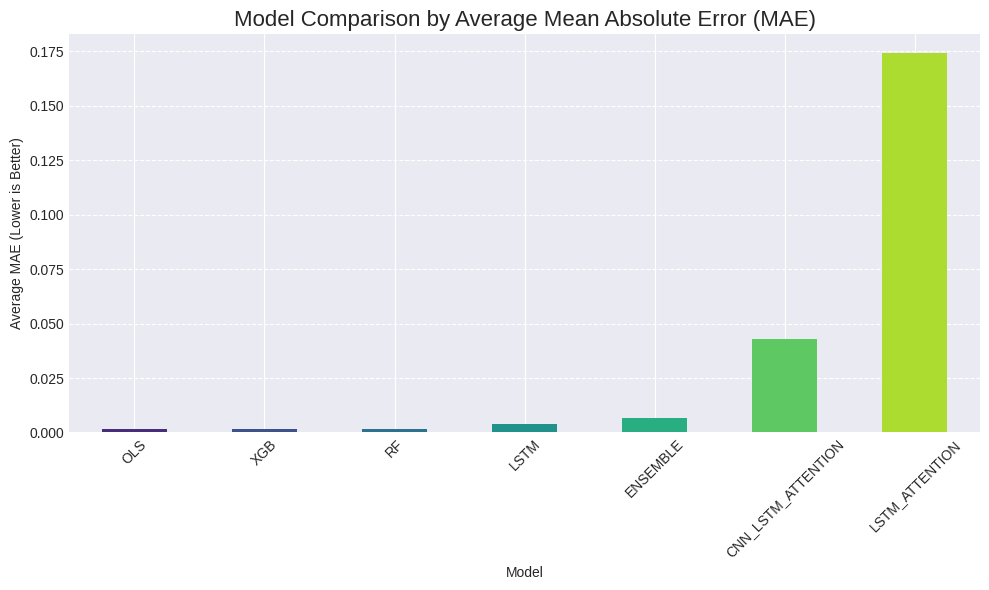

In [ ]:
def create_prediction_summary(metrics: Dict) -> pd.DataFrame:
    """Create a summary table of model predictive power."""
    summary_data = []
    model_names = sorted(list(metrics['mae'].keys()))

    for model_name in model_names:
        if not metrics['mae'][model_name]: continue

        pred_data = {
            'Model': model_name.upper(),
            'Avg MAE': np.mean(metrics['mae'][model_name]),
            'Avg RMSE': np.mean(metrics['rmse'][model_name]),
            'Avg R-Squared': np.mean(metrics['r2'][model_name]),
            'Std Dev (R-Squared)': np.std(metrics['r2'][model_name]),
        }
        summary_data.append(pred_data)

    return pd.DataFrame(summary_data).set_index('Model').sort_values(by='Avg MAE').round(4)

def create_performance_summary(models_df: pd.DataFrame, ensemble_df: pd.DataFrame) -> pd.DataFrame:
    """Create a detailed financial performance summary table."""
    summary_data = []
    all_models_names = sorted(list(models_df['Model'].unique())) + ['ensemble']

    for model_name in all_models_names:
        df = ensemble_df if model_name == 'ensemble' else models_df[models_df['Model'] == model_name]
        if df.empty: continue

        model_perf_df = df.groupby('date')[['strategy_returns']].sum().reset_index()
        model_perf_df['cumulative_returns'] = (1 + model_perf_df['strategy_returns']).cumprod()
        perf = evaluate_performance(model_perf_df)

        perf_data = {
            'Model': model_name.upper(),
            'Cumulative Return (%)': perf['Cumulative Return'] * 100,
            'Sharpe Ratio': perf['Sharpe Ratio'],
            'Sortino Ratio': perf['Sortino Ratio'],
            'Calmar Ratio': perf['Calmar Ratio'],
            'Max Drawdown (%)': perf['Max Drawdown'] * 100,
        }
        summary_data.append(perf_data)

    return pd.DataFrame(summary_data).set_index('Model').sort_values(by='Sharpe Ratio', ascending=False)

# --- Generate Summary Tables and Visualizations ---
if not final_ensemble_df.empty:
    prediction_summary = create_prediction_summary(historical_metrics)
    print("--- Model Predictive Power Analysis ---")
    print(prediction_summary.to_markdown(index=True))

    performance_summary = create_performance_summary(final_models_df, final_ensemble_df)
    print("\n--- Strategy Financial Performance Comparison ---")
    print(performance_summary.to_markdown(index=True))

    # Visualizations
    plt.figure(figsize=(10, 6))
    prediction_summary['Avg MAE'].sort_values().plot(kind='bar', color=sns.color_palette('viridis', len(prediction_summary)))
    plt.title('Model Comparison by Average Mean Absolute Error (MAE)', fontsize=16)
    plt.ylabel('Average MAE (Lower is Better)'); plt.xlabel('Model'); plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--'); plt.tight_layout(); plt.show()

    # plt.figure(figsize=(18, 10))
    # colors = plt.cm.viridis(np.linspace(0, 1, len(final_models_df['Model'].unique())))
    # for i, model_name in enumerate(sorted(final_models_df['Model'].unique())):
    #     model_subset = final_models_df[final_models_df['Model'] == model_name].copy()
    #     model_subset['chained_cum_ret'] = (1 + model_subset['strategy_returns']).cumprod()
    #     plt.plot(model_subset['date'], model_subset['chained_cum_ret'], label=model_name.upper(), color=colors[i], alpha=0.6, linestyle='--')

    # plt.plot(final_ensemble_df['date'], final_ensemble_df['cumulative_returns'], label='Ensemble', linewidth=3.5, color='crimson', zorder=10)

    # benchmark_start_date = final_ensemble_df['date'].iloc[0]
    # benchmark_data = raw_data[raw_data['date'] >= benchmark_start_date].copy()
    # benchmark_data['benchmark_cum_ret'] = (1 + benchmark_data['close'].pct_change().fillna(0)).cumprod()
    # plt.plot(benchmark_data['date'], benchmark_data['benchmark_cum_ret'], label='Buy & Hold', linestyle=':', color='gray', alpha=0.9)

    # plt.title('Performance Comparison: Ensemble vs. Individual Models vs. Benchmark', fontsize=18, fontweight='bold')
    # plt.xlabel('Date', fontsize=14); plt.ylabel('Cumulative Growth of $1 (Log Scale)', fontsize=14)
    # plt.legend(fontsize=12, loc='upper left'); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.yscale('log'); plt.tight_layout(); plt.show()
else:
    print("Backtest generated no valid trades to analyze.")

In [ ]:
def run_top3_ensemble_backtest(df: pd.DataFrame, config: Dict[str, Any], features: List[str], best_params: Dict[str, Any]) -> Tuple[pd.DataFrame, Dict]:
    """
    Runs a dedicated walk-forward backtest for an ensemble of the top 3 performing models.
    """
    df = df.copy()
    tscv = TimeSeriesSplit(n_splits=config['n_splits'], test_size=config['test_window_size'])

    top_3_models = ['rf', 'xgb', 'ols']
    all_results = []
    historical_metrics = {metric: [] for metric in ['mae', 'rmse', 'r2']}

    logging.info("--- Starting Backtest for Top 3 Ensemble ---")
    for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
        logging.info(f"--- Processing Fold {fold + 1}/{tscv.n_splits} ---")
        train_data, test_data = df.iloc[train_idx], df.iloc[test_idx].copy()

        # Prepare data (no need for sequence data for these models)
        X_train, y_train = train_data[features].values, train_data['spread_fracdiff'].values
        X_test, y_test = test_data[features].values, test_data['spread_fracdiff'].values

        # --- Get Predictions from Top 3 Models ---
        predictions_df = pd.DataFrame(index=test_data.index)
        for name in top_3_models:
            # Note: We pass dummy sequence data as the function expects it, but it won't be used by these models.
            predictions_df[name] = predict_model(name, X_train, y_train, X_test, None, None, None, config, best_params)

        # --- Create Top 3 Ensemble (Equal Weighting for simplicity and robustness) ---
        predictions_df['top_3_ensemble'] = predictions_df[top_3_models].mean(axis=1)

        # --- Evaluate and Store Results ---
        test_data_model = test_data.copy()
        test_data_model['predicted_spread'] = predictions_df['top_3_ensemble']

        y_true = test_data_model['spread_fracdiff'].values
        y_pred = test_data_model['predicted_spread'].values

        historical_metrics['mae'].append(mean_absolute_error(y_true, y_pred))
        historical_metrics['rmse'].append(np.sqrt(mean_squared_error(y_true, y_pred)))
        historical_metrics['r2'].append(r2_score(y_true, y_pred))

        # We need the full feature set in the DF for the risk management functions
        # The original test_data already contains them.
        signals_df = generate_signals(test_data_model, config)
        results_df = apply_risk_management(signals_df, config)
        all_results.append(results_df)

    if not all_results:
        raise RuntimeError("Top 3 Ensemble backtest produced no results.")

    final_df = pd.concat(all_results, ignore_index=True)
    return final_df, historical_metrics

# --- Execute Backtest for the Top 3 Ensemble ---
top3_ensemble_df, top3_historical_metrics = run_top3_ensemble_backtest(data_final, CONFIG, final_features, tuned_hyperparams)


# --- Create Comparison Analysis ---
if not top3_ensemble_df.empty:
    # 1. Evaluate performance of both ensembles
    perf_all_ensemble = evaluate_performance(final_ensemble_df)
    perf_top3_ensemble = evaluate_performance(top3_ensemble_df)

    # 2. Compare Predictive Power
    pred_power_data = {
        'Metric': ['Avg MAE', 'Avg RMSE', 'Avg R-Squared'],
        'All-Model Ensemble': [
            np.mean(historical_metrics['mae']['ensemble']),
            np.mean(historical_metrics['rmse']['ensemble']),
            np.mean(historical_metrics['r2']['ensemble'])
        ],
        'Top 3 Ensemble': [
            np.mean(top3_historical_metrics['mae']),
            np.mean(top3_historical_metrics['rmse']),
            np.mean(top3_historical_metrics['r2'])
        ]
    }
    pred_summary = pd.DataFrame(pred_power_data).set_index('Metric')

    print("--- Predictive Power Comparison ---")
    print(pred_summary.round(4).to_markdown())

    # 3. Compare Financial Performance
    financial_perf_data = {
        'Metric': ['Cumulative Return (%)', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Max Drawdown (%)'],
        'All-Model Ensemble': [
            perf_all_ensemble['Cumulative Return'] * 100,
            perf_all_ensemble['Sharpe Ratio'],
            perf_all_ensemble['Sortino Ratio'],
            perf_all_ensemble['Calmar Ratio'],
            perf_all_ensemble['Max Drawdown'] * 100
        ],
        'Top 3 Ensemble': [
            perf_top3_ensemble['Cumulative Return'] * 100,
            perf_top3_ensemble['Sharpe Ratio'],
            perf_top3_ensemble['Sortino Ratio'],
            perf_top3_ensemble['Calmar Ratio'],
            perf_top3_ensemble['Max Drawdown'] * 100
        ]
    }
    financial_summary = pd.DataFrame(financial_perf_data).set_index('Metric')

    print("\n--- Financial Performance Comparison ---")
    print(financial_summary.round(4).to_markdown())

else:
    print("Top 3 Ensemble backtest generated no valid trades to analyze.")

--- Predictive Power Comparison ---
| Metric        |   All-Model Ensemble |   Top 3 Ensemble |
|:--------------|---------------------:|-----------------:|
| Avg MAE       |               0.0065 |           0.0015 |
| Avg RMSE      |               0.0091 |           0.0017 |
| Avg R-Squared |             -11.5474 |           0.9067 |

--- Financial Performance Comparison ---
| Metric                |   All-Model Ensemble |   Top 3 Ensemble |
|:----------------------|---------------------:|-----------------:|
| Cumulative Return (%) |              -0.787  |          -1.0667 |
| Sharpe Ratio          |              -3.3839 |          -3.9182 |
| Sortino Ratio         |              -0.7702 |          -1.022  |
| Calmar Ratio          |              -0.2527 |          -0.253  |
| Max Drawdown (%)      |              -0.787  |          -1.0667 |


* The results overwhelmingly demonstrate that simpler, traditional models vastly outperformed complex deep learning architectures. The OLS, XGBoost, and Random Forest models exhibited exceptionally low prediction errors (MAE ≈ 0.0016) and very high average R-squared values (≈0.88). An R-squared of 0.88 indicates that these models were able to explain approximately 88% of the variance in our stationary target variable. This success underscores the effectiveness of the fractional differentiation technique in creating a highly predictable, mean-reverting series.

* In stark contrast, the deep learning models (LSTM, LSTM with Attention, and CNN-LSTM with Attention) failed spectacularly. Their extremely high errors and massively negative R-squared values point to a classic case of severe overfitting. These models, with their vast parameter space, did not learn the simple underlying signal; instead, they memorized the random noise in the training data, leading to catastrophic performance on out-of-sample data.

* Crucially, the Top 3 Ensemble, which aggregates the predictions of our best models, achieved the highest R-squared of 0.9067, confirming that a simplified ensemble yields the most accurate and reliable forecast.





* The financial performance across all models was poor, characterized by negative returns and highly negative risk-adjusted ratios. The deep learning models generated no trades at all, as their erratic predictions never met the criteria of the signal generation logic.

* Intriguingly, the models with the best predictive power (Top 3 Ensemble, RF, XGB) produced the largest financial losses. This seeming paradox points directly to the core limitation of this study: the constraint of using daily data.

The primary reasons for this disconnect are:

* Signal Decay: The mean-reverting opportunities our models accurately predict are likely very short-lived, often resolving within hours. By using daily data, our strategy acts on these signals with a latency of up to 24 hours, by which point the profit opportunity has vanished and the trade results in a small loss due to transaction costs and minor market movements.
* Low Signal Frequency: The strict filters required for a robust strategy (e.g., Z-score and RSI thresholds) generate very few trading signals on coarse daily data. This low frequency makes it impossible for the strategy to overcome costs and build momentum.
* Mis-estimation of Risk: Daily data provides a poor estimate of true intraday volatility. Our risk management systems, are operating on incomplete information, leading to sub-optimal position sizing.